In [ ]:
import ipywidgets as widgets
from IPython.display import display
import os

box_layout = widgets.Layout(
    display="flex",
    flex_flow="column",
    align_items="center",
    border="1px solid #E0E0E0",
    width="400px",
    padding="25px",
    border_radius="10px"
)

button_layout = widgets.Layout(width="100%", height="40px")

upload_layout = widgets.Layout(width="100%")

title = widgets.HTML(
    "<h3 style='margin-bottom:10px;'>Upload CSV Files 👇</h3>"
)

subtitle = widgets.HTML(
    "<p style='color:gray; margin-top:0;'>Select one or more CSV files to upload and save</p>"
)

train_uploader = widgets.FileUpload(
    accept='.csv',
    multiple=True,
    layout=upload_layout
)

save_button = widgets.Button(
    description='Save Files',
    button_style='primary',
    icon='save',
    layout=button_layout
)

status = widgets.HTML("<p style='color:gray;'>Waiting for upload...</p>")

output = widgets.Output()

def save_files(change=None):
    with output:
        output.clear_output()
        
        if train_uploader.value:
            saved_files = []
            for filename, file_info in train_uploader.value.items():
                with open(filename, "wb") as f:
                    f.write(file_info['content'])
                saved_files.append(filename)
            
            status.value = f"<p style='color:green;'>Saved {len(saved_files)} file(s) 👍</p>"
        else:
            status.value = "<p style='color:red;'>⚠️ No files uploaded yet</p>"

train_uploader.observe(save_files, names='value')

save_button.on_click(save_files)

card = widgets.VBox(
    [title, subtitle, train_uploader, save_button, status],
    layout=box_layout
)

display(card)
display(output)

Output()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('file.csv', usecols=['Age', 'Fare', 'Survived'])

In [4]:
df.dropna(inplace=True)

In [5]:
df.sample(3)

,Survived,Age,Fare
770,0,24.0,9.5
582,0,54.0,26.0
41,0,27.0,21.0


In [6]:
df.isnull().sum()

,0
Survived,0
Age,0
Fare,0


In [8]:
df.shape

(714, 3)

### **Results without binning**

In [9]:
x = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [10]:
X_train,X_test,y_train,y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=42
)

In [11]:
clf = DecisionTreeClassifier()

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test,y_pred)

0.6153846153846154

In [13]:
np.mean(cross_val_score(DecisionTreeClassifier(),x,y,cv=10,scoring='accuracy'))

np.float64(0.6331181533646322)

In [14]:
kbin_age = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=15,encode='ordinal',strategy='quantile')

In [15]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_fare,[1])
])

In [16]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [17]:
output = pd.DataFrame({
    'age':X_train['Age'],
    'age_trf':X_train_trf[:,0],
    'fare':X_train['Fare'],
    'fare_trf':X_train_trf[:,1]
})

In [19]:
output['age_labels'] = pd.cut(x=X_train['Age'],
                                    bins=trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x=X_train['Fare'],
                                    bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [21]:
output.head()

,age,age_trf,fare,fare_trf,age_labels,fare_labels
328,31.0,8.0,20.5250,8.0,"(30.0, 32.0]","(18.75, 26.0]"
73,26.0,6.0,14.4542,7.0,"(25.0, 28.0]","(13.0, 14.454]"
253,30.0,8.0,16.1000,7.0,"(28.0, 30.0]","(14.454, 18.75]"
719,33.0,9.0,7.7750,2.0,"(32.0, 35.0]","(7.25, 7.775]"
666,25.0,6.0,13.0000,6.0,"(23.0, 25.0]","(10.5, 13.0]"


In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,y_train)
y_pred2 = clf.predict(X_test_trf)

accuracy_score(y_test,y_pred2)

0.6363636363636364

In [29]:
def discretize(bins,strategy):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode='ordinal',strategy=strategy)
    
    trf = ColumnTransformer([
        ('first',kbin_age,[0]),
        ('second',kbin_fare,[1])
    ])
    
    X_trf = trf.fit_transform(x)
    print(np.mean(cross_val_score(DecisionTreeClassifier(),x,y,cv=10,scoring='accuracy')))
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(x['Age'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,0],color='red')
    plt.title("After")

    plt.show()
    
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.hist(x['Fare'])
    plt.title("Before")

    plt.subplot(122)
    plt.hist(X_trf[:,1],color='red')
    plt.title("Fare")

    plt.show()

0.6289123630672926


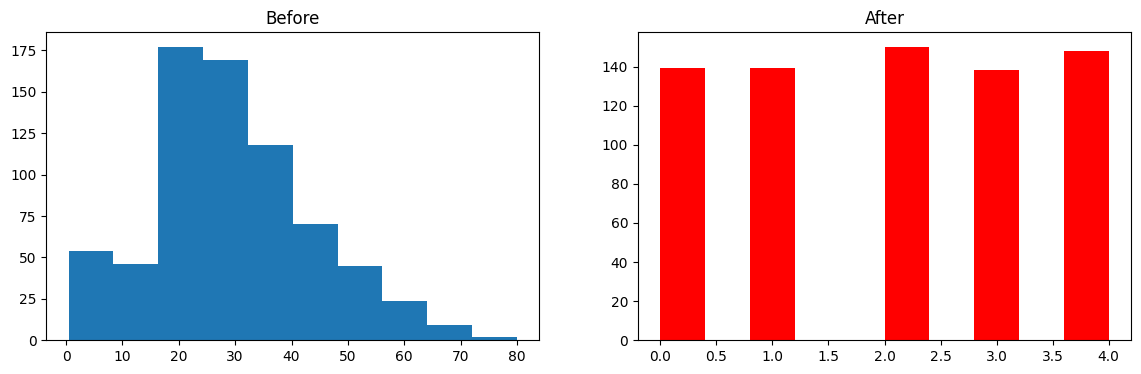

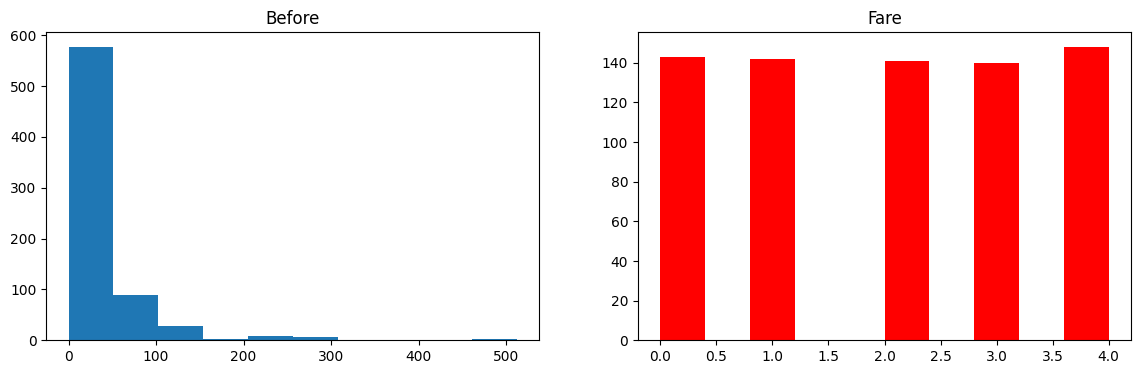

In [35]:
discretize(5,'quantile') # uniform, quantile, kmeans